In [1]:
# import dependecies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA # research PCA - have notes on goodnotes
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load datasets
data = pd.read_csv('personalFinanceDataset.csv')
syn = pd.read_csv('synData.csv')

In [3]:
data = data.drop('Unnamed: 0', axis=1)

In [4]:
targetColumn = 'financialHealth'

In [5]:
print('=' * 80)
print('DATASET COMPARISON DIAGNOSTICS')
print('=' * 80)

DATASET COMPARISON DIAGNOSTICS


In [6]:
print('\n1. BASIC DATASET STATISTICS')
print('=' * 80)
print('Original data shape:', data.shape)
print('Synthetic data shape:', syn.shape)
print('Original data columns:', list(data.columns))
print('Synthetic data columns:', list(syn.columns))


1. BASIC DATASET STATISTICS
Original data shape: (3500, 69)
Synthetic data shape: (3500, 69)
Original data columns: ['age', 'gender', 'raceEthnicity', 'education', 'region', 'householdType', 'householdSize', 'career', 'workArrangement', 'annualIncome', 'sideHustleIncome', 'monthlyIncome', 'housingStatus', 'housingCost', 'propertyTax', 'hoaFees', 'homeInsurance', 'utilities', 'internet', 'phone', 'ownsCar', 'carPayment', 'carInsurance', 'gas', 'publicTransit', 'carMaintenance', 'healthInsurance', 'oopMedical', 'dentalVision', 'lifeInsurance', 'studentLoans', 'ccPayment', 'personalLoans', 'medicalDebt', 'groceries', 'diningOut', 'coffee', 'alcohol', 'streaming', 'musicStreaming', 'gaming', 'gym', 'otherSubscriptions', 'clothing', 'personalCare', 'householdSupplies', 'childcare', 'petExpenses', 'entertainment', 'hobbies', 'travel', 'gifts', 'donations', 'retirement401k', 'iraContribution', 'emergencyFundContributions', 'generalSavings', 'investmentContributions', 'contributions529', 'tot

In [7]:
print('\n2. TARGET VARIABLE DISTRIBUTION COMPARISON')
print('-' * 80)


2. TARGET VARIABLE DISTRIBUTION COMPARISON
--------------------------------------------------------------------------------


In [8]:
ogTargetDist = data[targetColumn].value_counts().sort_index() # normalize makes the distribution percents vs numbers
synTargetDist = syn[targetColumn].value_counts().sort_index()

ogTargetProp = data[targetColumn].value_counts(normalize=True).sort_index()
synTargetProp = syn[targetColumn].value_counts(normalize=True).sort_index()

In [20]:
print('Original data target distribution', ogTargetDist)
print('Synthetic data target distribution', synTargetDist)

Original data target distribution financialHealth
FinanciallyDistressed    1704
FinanciallyStable         403
FinanciallyThriving       111
FinanciallyVulnerable    1282
Name: count, dtype: int64
Synthetic data target distribution financialHealth
FinanciallyDistressed    1598
FinanciallyStable         422
FinanciallyThriving       197
FinanciallyVulnerable    1283
Name: count, dtype: int64


In [ ]:
print('\nAbsolute difference in class proportions:')
for label in ogTargetProp.index:
    dataProp = ogTargetProp.get(label, 0)
    synProp = synTargetProp.get(label, 0)
    print(f' Class {label}: {abs(dataProp - synProp):.2f}')


Absolute difference in class proportions:
 Class FinanciallyDistressed: 0.03
 Class FinanciallyStable: 0.01
 Class FinanciallyThriving: 0.02
 Class FinanciallyVulnerable: 0.00


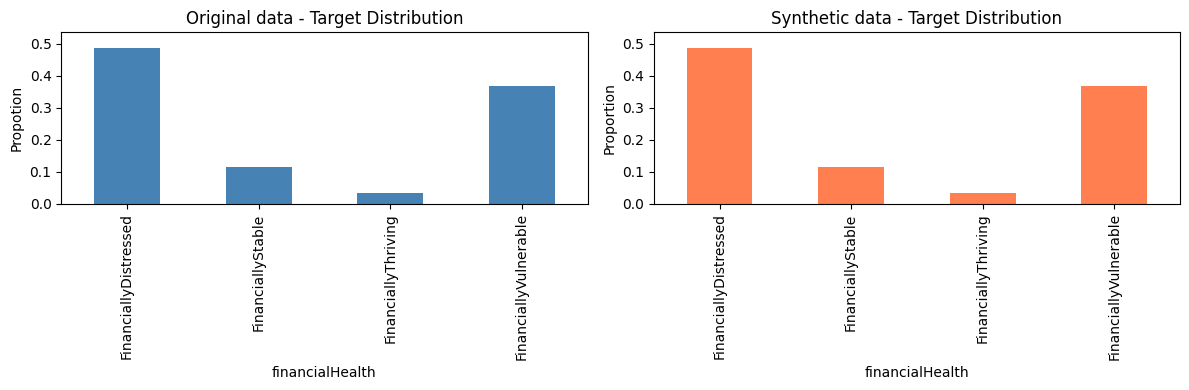

In [11]:
# visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ogTargetProp.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Original data - Target Distribution')
ax1.set_ylabel('Propotion')
ax1.set_ylim([0, max(ogTargetProp.max(), synTargetProp.max()) * 1.1])

ogTargetProp.plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Synthetic data - Target Distribution')
ax2.set_ylabel('Proportion')
ax2.set_ylim([0, max(ogTargetProp.max(), synTargetProp.max()) * 1.1])
plt.tight_layout()

In [12]:
print('\n3. NUMERICAL FEATURES STATISTICAL COMPARISON')
print('-' * 80)


3. NUMERICAL FEATURES STATISTICAL COMPARISON
--------------------------------------------------------------------------------



⚠ Features with significantly different distributions (p < 0.05):
  - age: KS p-value = 0.000000
  - householdSize: KS p-value = 0.000000
  - annualIncome: KS p-value = 0.000000
  - sideHustleIncome: KS p-value = 0.000000
  - monthlyIncome: KS p-value = 0.000000
  - housingCost: KS p-value = 0.000000
  - propertyTax: KS p-value = 0.000000
  - hoaFees: KS p-value = 0.000000
  - homeInsurance: KS p-value = 0.000000
  - utilities: KS p-value = 0.000000
  - internet: KS p-value = 0.000000
  - phone: KS p-value = 0.000000
  - carPayment: KS p-value = 0.000000
  - carInsurance: KS p-value = 0.000000
  - gas: KS p-value = 0.000000
  - publicTransit: KS p-value = 0.000000
  - carMaintenance: KS p-value = 0.000000
  - healthInsurance: KS p-value = 0.000000
  - oopMedical: KS p-value = 0.000000
  - dentalVision: KS p-value = 0.000000
  - lifeInsurance: KS p-value = 0.000000
  - studentLoans: KS p-value = 0.000000
  - ccPayment: KS p-value = 0.000000
  - personalLoans: KS p-value = 0.000000
  - 

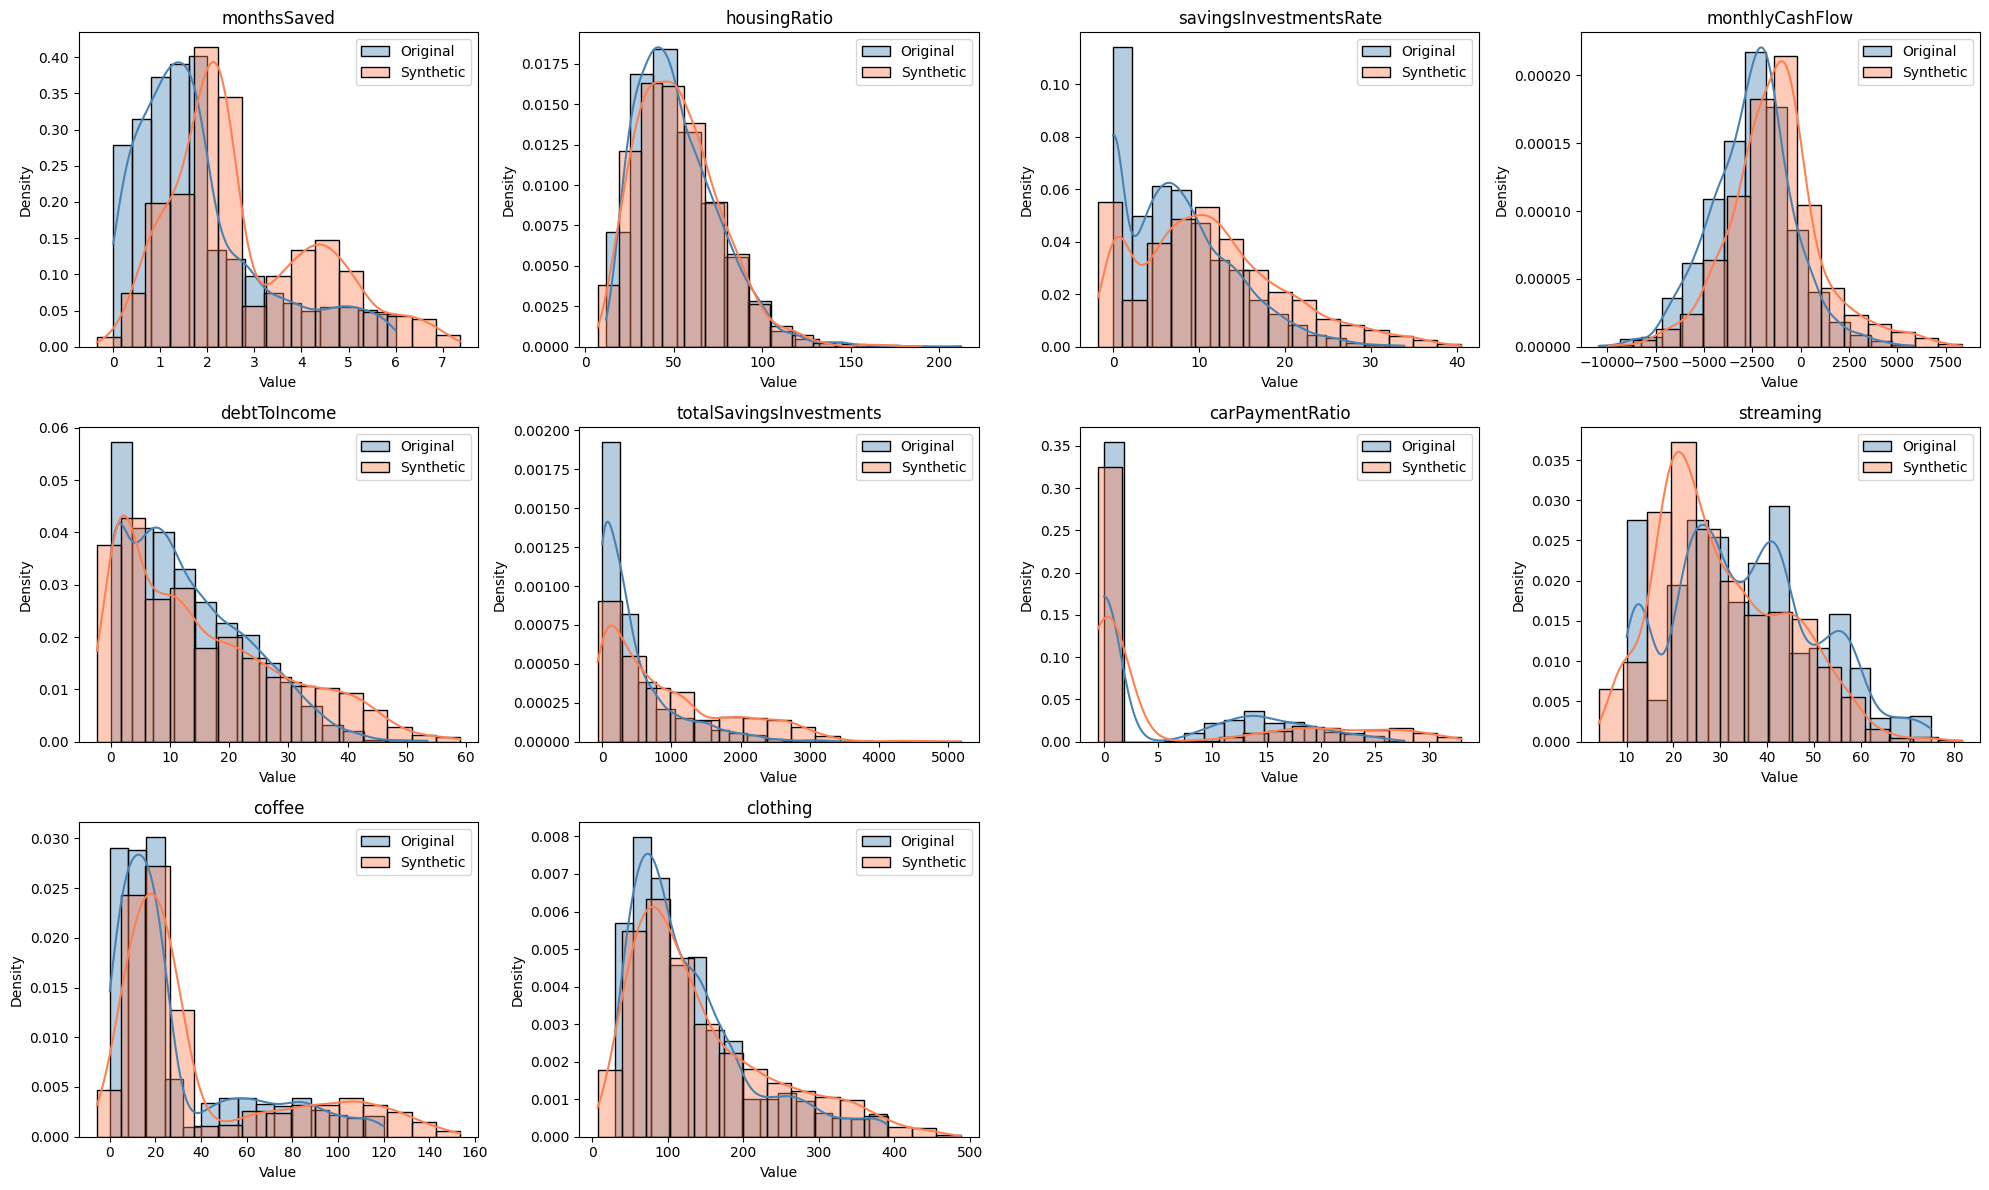

In [13]:
# identify numerical columns
numericCols = data.select_dtypes('number').columns.tolist()

if len(numericCols) > 0:
    comparisons = pd.DataFrame()

    for col in numericCols:
        ogMean = data[col].mean()
        ogStd = data[col].std()
        ogMin = data[col].min()
        ogMax = data[col].max()
        
        synMean = syn[col].mean()
        synStd = syn[col].std()
        synMin = syn[col].min()
        synMax = syn[col].max()
        
        # perform Kolmogorov-Smirnov test : 2 samples from same distribution? p-value > 0.05 = distributions similar
        ksStatistic, ksPvalue = stats.ks_2samp(
            data[col].dropna(),
            syn[col].dropna()
        )
        
        comparisons = pd.concat([comparisons, pd.DataFrame({
            'Feature': [col],
            'ogMean': [ogMean],
            'synMean': [synMean],
            'meanDifference': [abs(ogMean - synMean)],
            'ogStd': [ogStd],
            'synStd': [synStd],
            'ogRange': [f'{ogMin:.2f} to {ogMax:.2f}'],
            'synRange': [f'{synMin:.2f} to {synMax:.2f}'],
            'ksStatistic': [ksStatistic],
            'ksPvalue': [ksPvalue]
            })], ignore_index=True)
        
    print("\n⚠ Features with significantly different distributions (p < 0.05):")
    probFeatures = comparisons[comparisons['ksPvalue'] < 0.05]
    if len(probFeatures) > 0:
        for _, row in probFeatures.iterrows():
            print(f"  - {row['Feature']}: KS p-value = {row['ksPvalue']:.6f}")
    else:
        print("  None found (all distributions similar)")
    
    # plotting distributions of top 10 numerical features in xg boost (add'l evidence of huge breakthrough in understanding where the GAN dataset doesn't match up)
    top10 = ['monthsSaved', 'housingRatio', 'savingsInvestmentsRate', 'monthlyCashFlow', 
            'debtToIncome', 'totalSavingsInvestments', 'carPaymentRatio', 
            'streaming', 'coffee', 'clothing']

    # this code creates the grid of plots of histograms overlaying each dataset's distributions
    nCols = min(4, len(top10))
    nRows = (len(top10) + nCols - 1) // nCols
    
    # want to add a kde to my histograms - making updates
    fig, axes = plt.subplots(nRows, nCols, figsize=(5*nCols, 4*nRows))
    if nRows == 1:
        axes = axes.reshape(1, -1) # ensures axes are always 2d
    axes = axes.flatten()

    for idx, col in enumerate(top10):
        ax = axes[idx]
        # og histogram w/ kde
        sns.histplot(data[col].dropna(), bins=15, stat='density', kde=True, label='Original', color='steelblue', alpha=0.4, ax=ax)
        # syn histogram w/ kde
        sns.histplot(syn[col].dropna(), bins=15, stat='density', kde=True, label='Synthetic', color='coral', alpha=0.4, ax=ax)
        ax.set_title(f'{col}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()
        
    # hides empty subplots if any
    for idx in range(len(top10), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
else:
    print('No numerical features found.')

huge huge huge metrics here; multiple top 10 features have largest mean differences.

In [14]:
comparisons.head()

,Feature,ogMean,synMean,meanDifference,ogStd,synStd,ogRange,synRange,ksStatistic,ksPvalue
0,age,40.064286,45.315429,5.251143,12.041660,14.060070,25.00 to 70.00,23.00 to 79.00,0.212571,1.256539e-69
1,householdSize,2.455429,2.232000,0.223429,1.220250,1.062443,1.00 to 5.00,1.00 to 6.00,0.128286,1.659881e-25
2,annualIncome,59539.278108,35983.476798,23555.801310,33832.018375,23980.971833,12155.92 to 201295.13,-12310.92 to 178679.30,0.372571,1.460065e-216
3,sideHustleIncome,1546.698483,545.523905,1001.174578,3892.535837,2713.508204,0.00 to 32971.11,-607.29 to 36790.85,0.482857,0.000000e+00
4,monthlyIncome,5090.498049,5396.302800,305.804751,2918.055046,3507.714084,1012.99 to 18897.11,-241.38 to 19778.13,0.071143,4.002103e-08


In [15]:
print('\n4. CATEGORICAL FEATURES COMPARISON')
print('-' * 80)


4. CATEGORICAL FEATURES COMPARISON
--------------------------------------------------------------------------------


In [16]:
catCols = data.select_dtypes(include=['object']).columns.tolist()
if targetColumn in catCols:
    catCols.remove(targetColumn)

if len(catCols) > 0:
    for col in catCols:
        print(f'\nFeature: {col}')

        # getting value counts
        ogCounts = data[col].value_counts(normalize=True)
        synCounts = syn[col].value_counts(normalize=True)
        
        # check if cats match
        ogCats = set(ogCounts.index)
        synCats = set(synCounts.index)
        
        if ogCats != synCats:
            print(f' ⚠ WARNING: Category mismatch!')
            print(f' Categories only in original: {ogCats - synCats}')
            print(f' Categories only in synthetic: {synCats - ogCats}')
        
        # perform chi-squared test on common categories
        commonCats = ogCats.intersection(synCats)
        if len(commonCats) > 1:
            # create contigency table
            ogFreq = data[col].value_counts()
            synFreq = syn[col].value_counts()
            
            contingencyTable = pd.DataFrame({
                'Original': [ogFreq.get(cat, 0) for cat in commonCats],
                'Synthetic': [synFreq.get(cat, 0) for cat in commonCats]
            }, index=list(commonCats))
            
            # p-value > 0.05 suggests similar distributions
            chi2, pValue, dof, expected = stats.chi2_contingency(contingencyTable.T)
            print(f' Chi-squared test p-value: {pValue:.6f}')
            if pValue < 0.05:
                print(' ⚠ Significant difference in distributions')
        # showing top categories comparison
        catComparisons = pd.DataFrame({
            'Original': ogCounts.head(10),
            'Synthetic': synCounts.head(10)
        }).fillna(0)
else:
    print('No categorical features found besides target')


Feature: gender
 Chi-squared test p-value: 0.362757

Feature: raceEthnicity
 Chi-squared test p-value: 0.000000
 ⚠ Significant difference in distributions

Feature: education
 Chi-squared test p-value: 0.000000
 ⚠ Significant difference in distributions

Feature: region
 Chi-squared test p-value: 0.218725

Feature: householdType
 Chi-squared test p-value: 0.000000
 ⚠ Significant difference in distributions

Feature: career
 Chi-squared test p-value: 0.000000
 ⚠ Significant difference in distributions

Feature: workArrangement
 Chi-squared test p-value: 0.000000
 ⚠ Significant difference in distributions

Feature: housingStatus
 Chi-squared test p-value: 0.282051

Feature: ageCategory
 Chi-squared test p-value: 0.000000
 ⚠ Significant difference in distributions


In [17]:
print('\n5. CORRELATION STRUCTURE COMPARISON')
print('-' * 80)


5. CORRELATION STRUCTURE COMPARISON
--------------------------------------------------------------------------------


Mean absolute correlation difference: 0.1187
(Lower is better - 0.0 means perfect match, 1.0 means completely different)

Creating detailed correlation comparison dataframe...

--------------------------------------------------------------------------------
ANALYSIS: Do strong correlations in the original data get preseverd in the synthetic data?
--------------------------------------------------------------------------------

Strong correlations in the original data (|r| > 0.5): 78 pairs
 Average preservation error: 0.6505
 Worst case error: 0.9625

Moderate correlations in the original data (0.3 < |r| < 0.5): 125 pairs
 Average preservation error: 0.3849
 Worst case error: 0.5211

Weak correlations in the original data (|r| > 0.3): 1450 pairs
Average preservation error: 0.0671
Worst case error: 0.3282

⚠ Feature pairs with large correlation differences (>0.7):
 - householdSize vs utilities: Orignial = 0.81, Synthetic = 0.01, Diff = 0.80
 - householdSize vs phone: Orignial = 0.81, Syn

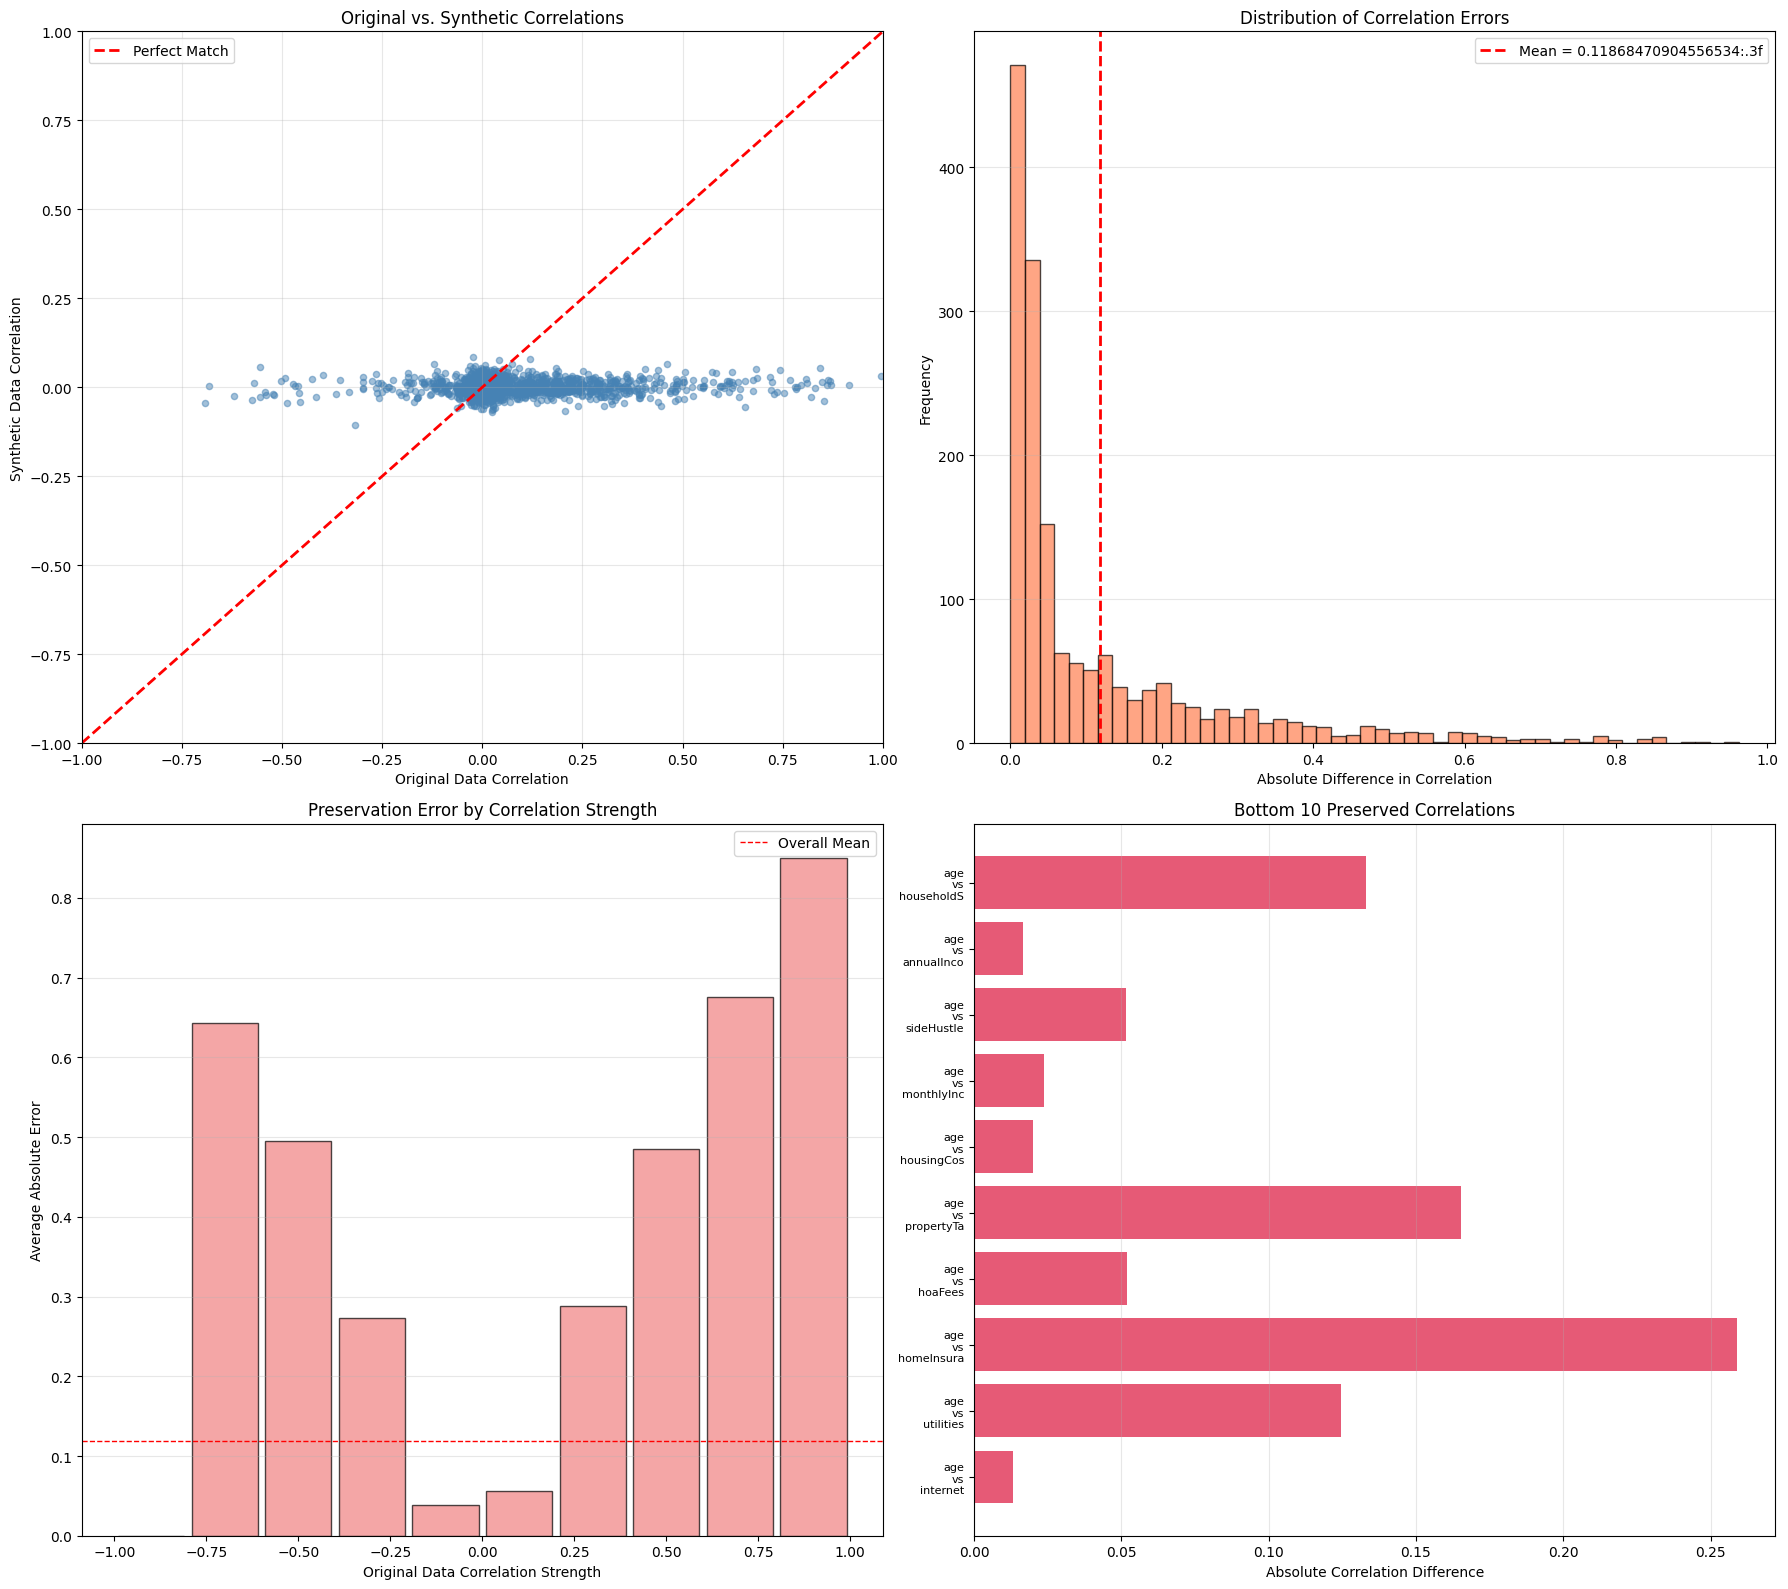

In [21]:
if len(numericCols) > 1:
    ogCorr = data[numericCols].corr()
    synCorr = syn[numericCols].corr()
    
    corrDiff = np.abs(ogCorr - synCorr)
    meanCorrDiff = corrDiff.values[np.triu_indices_from(corrDiff.values, k=1,)].mean() # np.triu grabs the upper triangle of the cm; k=1 exlcudes the diagonal
    print(f'Mean absolute correlation difference: {meanCorrDiff:.4f}')
    print(f'(Lower is better - 0.0 means perfect match, 1.0 means completely different)')
    
    # creating correlation comparison dataframe
    print('\nCreating detailed correlation comparison dataframe...')
    corrComp = []
    
    # gonna loop through upper triangle of cm
    for i in range(len(numericCols)):
        for j in range(i+1, len(numericCols)):
            feature1 = numericCols[i]
            feature2 = numericCols[j]
            ogCorrValue = ogCorr.iloc[i, j]
            synCorrValue = synCorr.iloc[i, j]
            absDiff = corrDiff.iloc[i, j]
            
            corrComp.append({
                'Feature1': feature1,
                'Feature2': feature2,
                'OriginalCorrelation': ogCorrValue,
                'SyntheticCorrelation': synCorrValue,
                'AbsoluteDifference': absDiff,
                'PercentChange': abs((ogCorrValue - synCorrValue) / (ogCorrValue + 1e-10)) * 100
            })
    
    corrComp = pd.DataFrame(corrComp)
    
    # big question : do strong correlations in original data get preserved in the synthetic data?
    print('\n' + '-' * 80)
    print('ANALYSIS: Do strong correlations in the original data get preseverd in the synthetic data?')
    print('-' * 80)
    
    # categorize correlations by strength
    ogStrongCorr = corrComp[abs(corrComp['OriginalCorrelation']) > 0.5]
    ogModerateCorr = corrComp[
        (abs(corrComp['OriginalCorrelation']) > 0.3) & 
        (abs(corrComp['OriginalCorrelation']) <= 0.5)
    ]
    ogWeakCorr = corrComp[abs(corrComp['OriginalCorrelation']) <= 0.3]
    
    print(f'\nStrong correlations in the original data (|r| > 0.5): {len(ogStrongCorr)} pairs')
    if len(ogStrongCorr) > 0:
        print(f' Average preservation error: {ogStrongCorr["AbsoluteDifference"].mean():.4f}')
        print(f' Worst case error: {ogStrongCorr["AbsoluteDifference"].max():.4f}')
    
    print(f'\nModerate correlations in the original data (0.3 < |r| < 0.5): {len(ogModerateCorr)} pairs')
    if len(ogModerateCorr) > 0:
        print(f' Average preservation error: {ogModerateCorr["AbsoluteDifference"].mean():.4f}')
        print(f' Worst case error: {ogModerateCorr["AbsoluteDifference"].max():.4f}')
    
    print(f'\nWeak correlations in the original data (|r| > 0.3): {len(ogWeakCorr)} pairs')
    if len(ogWeakCorr) > 0:
        print(f'Average preservation error: {ogWeakCorr["AbsoluteDifference"].mean():.4f}')
        print(f'Worst case error: {ogWeakCorr["AbsoluteDifference"].max():.4f}')
    
    # visualizationssss
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    
    # plt 1: scatter; og vs syn correlations; perfect match would be diagonal line
    axes[0, 0].scatter(corrComp['OriginalCorrelation'], 
                       corrComp['SyntheticCorrelation'],
                       alpha=0.5, s=20, color='steelblue')
    axes[0, 0].plot([-1, 1], [-1, 1], 'r--', label='Perfect Match', linewidth=2)
    axes[0, 0].set_xlabel('Original Data Correlation')
    axes[0, 0].set_ylabel('Synthetic Data Correlation')
    axes[0, 0].set_title('Original vs. Synthetic Correlations')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].set_xlim([-1, 1])
    axes[0, 0].set_ylim([-1, 1])
    
    # plt 2: distribution of absolute differences
    axes[0, 1].hist(corrComp['AbsoluteDifference'], bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(meanCorrDiff, color='red', linestyle='--', linewidth=2, label=f'Mean = {meanCorrDiff}:.3f')
    axes[0, 1].set_xlabel('Absolute Difference in Correlation')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Correlation Errors')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # plt 3: error by correlation strength; shows if gan struggles more with strong/vs correlations
    bins = np.arange(-1, 1.1, 0.2) # creates bins going from -1 to 1 stepping by 0.2 correlation *units*
    binCenters = (bins[:-1] + bins[1:]) / 2 # averages adjancent pairs of bins to then use on x-axis of bar chat
    binIndices = np.digitize(corrComp['OriginalCorrelation'], bins) # assigns each correlation to a bin
    binMeans = [corrComp[binIndices == i]['AbsoluteDifference'].mean()
                if sum(binIndices == i) > 0 else 0
                for i in range(1, len(bins))]
    axes[1, 0].bar(binCenters, binMeans, width=0.18, color='lightcoral',
                   edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Original Data Correlation Strength')
    axes[1, 0].set_ylabel('Average Absolute Error')
    axes[1, 0].set_title('Preservation Error by Correlation Strength')
    axes[1, 0].grid(alpha=0.3, axis='y')
    axes[1, 0].axhline(meanCorrDiff, color='red', linestyle='--', linewidth=1, label='Overall Mean')
    axes[1, 0].legend()
    
    worst10 = corrComp.head(10).copy()
    worst10["Pair"] = worst10['Feature1'].str[:10] + '\nvs\n' + worst10['Feature2'].str[:10]
    
    xPos = np.arange(len(worst10))
    axes[1, 1].barh(xPos, worst10['AbsoluteDifference'], color='crimson', alpha=0.7)
    axes[1, 1].set_yticks(xPos)
    axes[1, 1].set_yticklabels(worst10['Pair'], fontsize=8)
    axes[1, 1].set_xlabel('Absolute Correlation Difference')
    axes[1, 1].set_title('Bottom 10 Preserved Correlations')
    axes[1, 1].grid(alpha=0.3, axis='x')
    axes[1, 1].invert_yaxis()
    
    plt.tight_layout()
    
    # identify pairs w/ large corrleation differences
    print('\n⚠ Feature pairs with large correlation differences (>0.7):')
    for i in range(len(numericCols)):
        for j in range(i+1, len(numericCols)):
            diff = corrDiff.iloc[i, j]
            if diff > 0.7:
                print(f" - {numericCols[i]} vs {numericCols[j]}: "
                      f"Orignial = {ogCorr.iloc[i, j]:.2f}, "
                      f"Synthetic = {synCorr.iloc[i, j]:.2f}, "
                      f"Diff = {diff:.2f}")
    
else:
    print('Not enough numerical features for correlation analysis.')  


6. PCA VISUALIZATION (Data Overlap Check)
--------------------------------------------------------------------------------


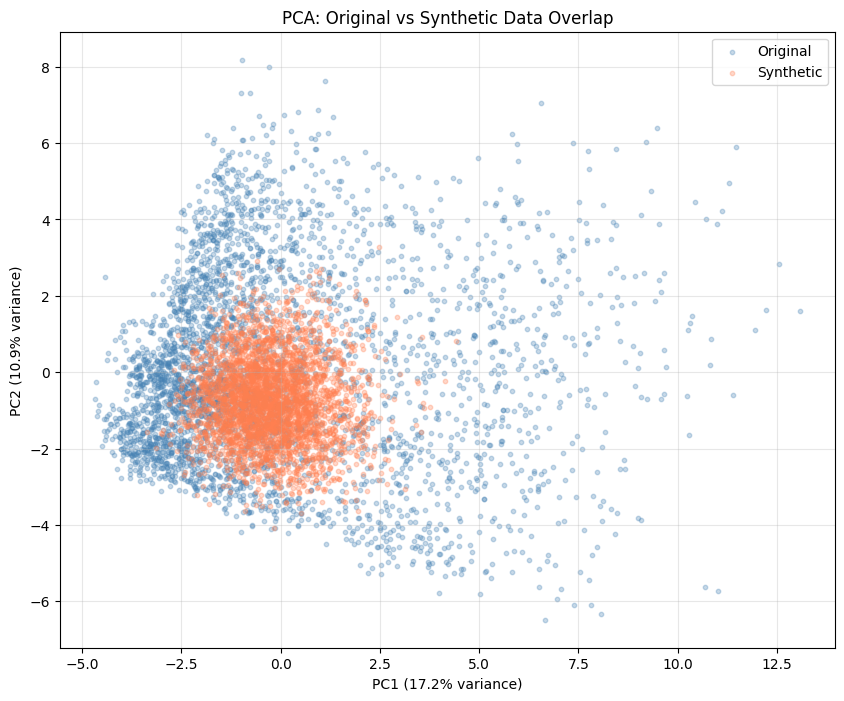

In [ ]:
print('\n6. PCA VISUALIZATION (Data Overlap Check)')
print('-' * 80)

if len(numericCols) > 0:
    ogFeatures = data[numericCols].fillna(data[numericCols].mean())
    synFeatures = syn[numericCols].fillna(syn[numericCols].mean())
    
    scaler = StandardScaler()
    scaler.fit(ogFeatures)
    
    ogFeatures = scaler.transform(ogFeatures)
    synFeatures = scaler.transform(synFeatures)
    
    pca = PCA(n_components=2)
    pca.fit(ogFeatures)
    
    ogPCA = pca.transform(ogFeatures)
    synPCA = pca.transform(synFeatures)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(ogPCA[:, 0], ogPCA[:, 1], alpha=0.3, s=10, label='Original', color='steelblue')
    plt.scatter(synPCA[:, 0], synPCA[:, 1], alpha=0.3, s=10, label='Synthetic', color='coral')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('PCA: Original vs Synthetic Data Overlap')
    plt.legend()
    plt.grid(alpha=0.3)
else:
    print('Cannot perform PCA - no numerical features.')